<a href="https://colab.research.google.com/github/kundajelab/gkmexplain/blob/master/Figure1ToyExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#install lsgkm
!rm -rf lsgkm
! git clone https://github.com/kundajelab/lsgkm
% cd lsgkm/src
! make
! ./gkmtrain
%cd ../..

Cloning into 'lsgkm'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 296 (delta 1), reused 1 (delta 0), pack-reused 289
Receiving objects: 100% (296/296), 492.85 KiB | 8.96 MiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmexplain.c libsvm.o libsvm_gkm.o -o gkmexplain -lm -lpthread

Usage: gkmtrain [options] <posfile> <negfile> <outprefix>

 train gkm-SVM using libSVM

Arguments:
 posfile: positive sequence file (FASTA format)
 negfile: negative sequence file (FASTA format)
 outprefix: prefix of output file(s) <outprefix>.model.txt or
            <outpre

In [210]:

model_settings = """
svm_type c_svc
kernel_type gkmrbf
L 4
k 3
d 1
gamma 3
nr_class 2
total_sv 3
rho 0.0
label 1 -1
nr_sv 1 2
SV
2 TATAGGGCCGG
-0.5 TATA
-0.5 CCGG
"""
model_file="model.txt"
open(model_file,'w').write(model_settings)

theseq = "TATAATTTATAATTCCGG"
sequences = """>test
"""+theseq+"""
>test2
TATGATTTATAATTCCGG
>SV1
TATAGGGCCGG
>SV2
TATA
>SV3
CCGG"""
open("test_sequences.fa",'w').write(sequences)


87

In [211]:
!lsgkm/src/gkmpredict test_sequences.fa model.txt preds.txt
!cat preds.txt

INFO 2019-03-19 22:57:40: Number of threads is set to 1
INFO 2019-03-19 22:57:40: load model model.txt
INFO 2019-03-19 22:57:40: write prediction result to preds.txt
INFO 2019-03-19 22:57:40: 5 scored
test	0.106928
test2	0.118632
SV1	1.83597
SV2	-0.196836
SV3	-0.196836


In [212]:
!pip install vizsequence

In [0]:

def run_ism(model_file_path,sequence,temp_filepath):
  
  letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3, 'N': -1}
  
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  fh.close()
  explanation_file = temp_filepath+".explanation.txt"
  !lsgkm/src/gkmexplain $temp_filepath $model_file_path $explanation_file
  
  gkmexplain_impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explanation_file)
  ][0]

  
  seq_len = len(sequence)
  fh = open(temp_filepath,'w')
  fh.write(">orig_seq\n")
  fh.write(sequence+"\n")
  
  onehot_seq = np.zeros((seq_len,4))  
  for pos in range(seq_len):
    orig_letter_idx = letter_to_idx[sequence[pos]]
    if (orig_letter_idx != -1):
      onehot_seq[pos,orig_letter_idx] = 1
    for letter in ['A','C','G','T']:
      #only need to compute scores for perturbations
      if (letter != sequence[pos]):
        letter_idx = letter_to_idx[letter]
        fh.write(">pos-"+str(pos)+"_base-"+str(letter_idx)+"\n")
        fh.write(sequence[:pos]+letter+sequence[pos+1:]+"\n")
  fh.close()
  
  predictions_file = temp_filepath+".preds.txt"
  !lsgkm/src/gkmpredict $temp_filepath $model_file_path $predictions_file
    
  ism_importance_scores = np.zeros((seq_len,4))
  for line in open(predictions_file):
    seq_name,pred = line.rstrip().split("\t")
    pred = float(pred)
    if (seq_name=="orig_seq"):
      orig_pred = pred
    else:
      pos,letter_idx = seq_name.split("_")
      pos = int(pos.split("-")[1])
      letter_idx = int(letter_idx.split("-")[1])
      ism_importance_scores[pos,letter_idx] = (pred - orig_pred)
  
  !rm $temp_filepath
  !rm $predictions_file
  !rm $explanation_file
  
  ism_hyp_importance_scores = ism_importance_scores-np.mean(ism_importance_scores,axis=1)[:,None]
  ism_importance_scores = ism_hyp_importance_scores*onehot_seq
  
  return ism_importance_scores, ism_hyp_importance_scores, gkmexplain_impscores

INFO 2019-03-19 23:01:02: Number of threads is set to 1
INFO 2019-03-19 23:01:02: load model model.txt
INFO 2019-03-19 23:01:02: write prediction result to tmp.explanation.txt
INFO 2019-03-19 23:01:02: 1 scored
INFO 2019-03-19 23:01:04: Number of threads is set to 1
INFO 2019-03-19 23:01:04: load model model.txt
INFO 2019-03-19 23:01:04: write prediction result to tmp.preds.txt
INFO 2019-03-19 23:01:04: 55 scored


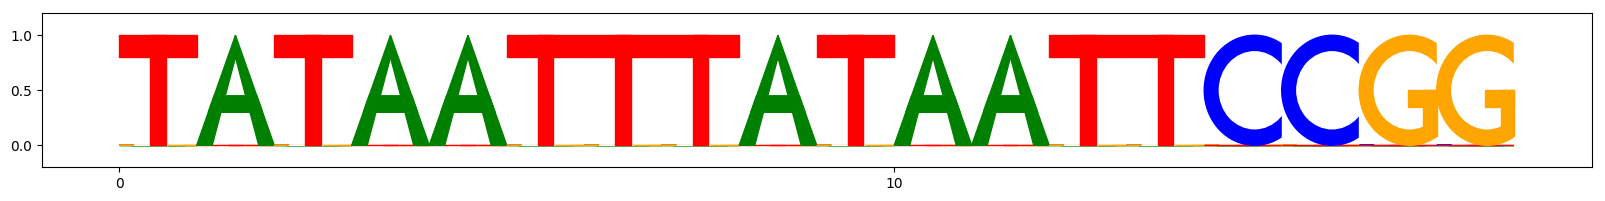

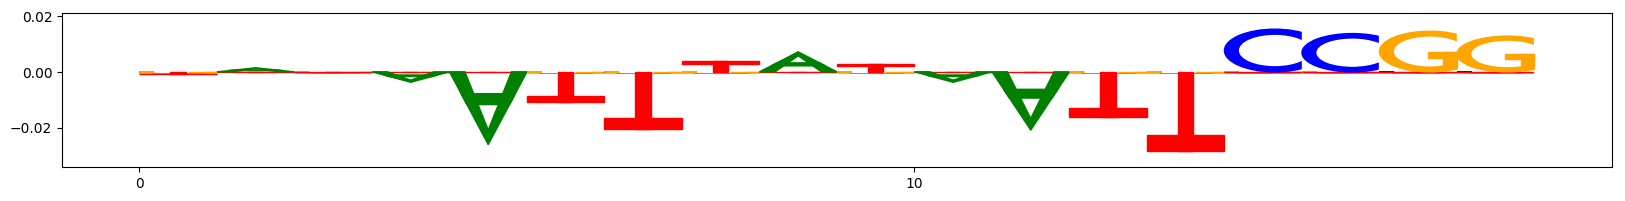

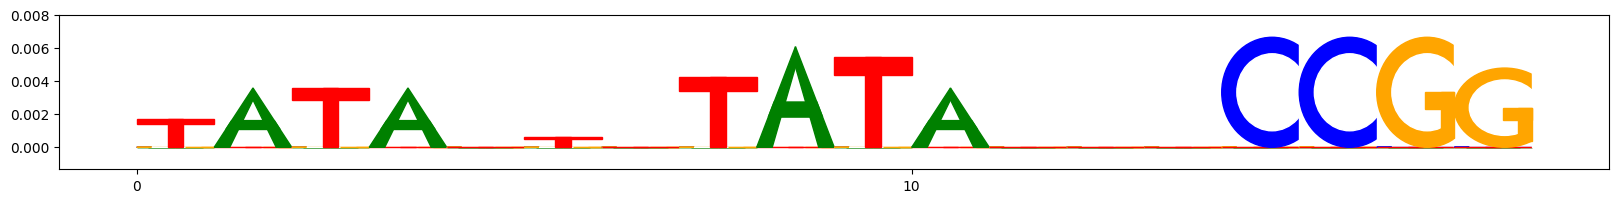

In [215]:
ism_scores, ism_hyp_imp_scores, gkmexplain_scores = run_ism(model_file_path=model_file,
        sequence=theseq, temp_filepath="tmp")

viz_sequence.plot_weights(np.abs(ism_scores)>0.0, subticks_frequency=10)
viz_sequence.plot_weights(ism_scores, subticks_frequency=10)
viz_sequence.plot_weights(gkmexplain_scores, subticks_frequency=10)